# steps

1. import water body 
1. get bounds
1. format bounds to string
1. use requests to download geojson for area
1. calculate overlap 
1. add data to shapes


In [137]:
import requests

In [138]:
def download_file(url, local):
    
    local_filename = local
    
    r = requests.get(url, stream=True)
    
    with open(local_filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                
    return local_filename

def check_valid_geometries(shapefile_path):
    
    shape_list = []
    
    # check crs
    if fiona.open(shapefile_path).crs['init'] != 'epsg:4326':
        print('crs is not epsg:4326, skipping...')
        
        crs_check = False
    else:
        crs_check = True
        
    data = []

    for pol in fiona.open(shapefile_path):
        if pol['geometry'] != None:
                shape_list.append(pol)
                data.append(pol)
            
    return shape_list, data, crs_check

In [139]:
import overpass
import fiona
import glob

from shapely.ops import cascaded_union, unary_union
from shapely.geometry import shape, Point

In [144]:
# parameters 
results_files_location = '../../data/nir_green_blue/vectors/'

persil_data_store_location = '../../data/nir_green_blue/persil_overlap/'

geoserver_url = 'https://geosvc.atrbpn.go.id/geoserver/petabpn/'

In [148]:
# create download directory if it does not exist
import os

try:
    # Create  Directory  MyDirectory 
    os.mkdir(persil_data_store_location)
    #print if directory created successfully...
    print("Directory " , persil_data_store_location ,  " Created") 
except FileExistsError:
    ##print if directory already exists...
    print("Directory " , persil_data_store_location ,  " already exists...")
    

Directory  ../../data/nir_green_blue/persil_overlap/  Created


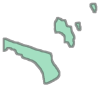

In [149]:
result_file_list = glob.glob(results_files_location + '*.geojson')

result_file_path = result_file_list[0]

# convert esri shapefiles to shapely objects
# check valid geometries
list, result_valid_shape_list, crs_check = check_valid_geometries(result_file_path)

if not crs_check:
    print('crs not epsg:4623, skipping...')


# convert list to shapely MultiPolgyons (in wgs84)
result_wgs_shp = unary_union([shape(pol['geometry']) for pol in result_valid_shape_list])

result_wgs_shp

In [159]:
basename = os.path.basename(result_file_path).split('.')[0]

In [160]:
xmin, ymin, xmax, ymax = result_wgs_shp.bounds ##116.875357555,-1.256141483,116.881267105,-1.248372542

max_features = 100000

xmin, ymin, xmax, ymax, max_features

(98.65659940698526,
 3.622088321591808,
 98.65857946447719,
 3.623799245055695,
 100000)

In [161]:
url = geoserver_url + 'ows?service=WFS&version=1.0.0&request=GetFeature&typeName=petabpn:PersilBerdasarkanJenisHak&maxFeatures={}&outputFormat=application%2Fjson&BBOX={},{},{},{}'.format(
        max_features, xmin, ymin, xmax, ymax)

local = persil_data_store_location + basename + '.geojson'

In [162]:
download_file(url, local)

'../../data/nir_green_blue/persil_overlap/Medan_017_pansharpen_True_2020-03-03_04:05_10300100A367E500_05-18-2020_08:55:26.geojson'

In [163]:
import fiona
from shapely.geometry import shape
from shapely.ops import unary_union

In [164]:
valid_geom, data, crs_check = check_valid_geometries(local)

polygon_list_wgs_shp = [shape(pol['geometry']) for pol in valid_geom]

typehak = []
for feature in data:
    typehak.append(feature['properties']['TIPEHAK'])

import geopandas as gpd

series = gpd.GeoSeries(polygon_list_wgs_shp)

gdf = gpd.GeoDataFrame(geometry = series)

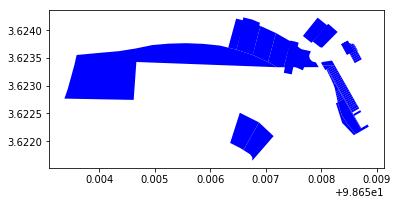

In [165]:
# We can now plot our ``GeoDataFrame``.
gdf.plot(color='b', facecolor = 'white')

In [166]:
import folium



import pandas as pd

try:
    x,y = result_wgs_shp[0].centroid.xy
except:
    x,y = result_wgs_shp.centroid.xy

m = folium.Map(location=[y[0], x[0]], zoom_start=16, max_zoom = 30)

for poly in polygon_list_wgs_shp[0:500]:
    folium.Choropleth(
        geo_data=poly,
        legend_name='persil data'
    ).add_to(m)
    

for poly in [result_wgs_shp]:
    folium.Choropleth(
        geo_data=poly, 
        name='detected water',
    ).add_to(m)


folium.LayerControl().add_to(m)

m

In [167]:
dict((i, typehak.count(i)) for i in typehak)

{'Hak Pakai': 1, 'Hak Guna Bangunan': 38, 'Hak Milik': 27, 'Kosong': 6}

In [168]:
import numpy as np
import matplotlib.pyplot as plt

In [169]:
typehak_count = [typehak.count(i) for i in np.unique(typehak)]

Text(0, 0.5, 'number of occurences')

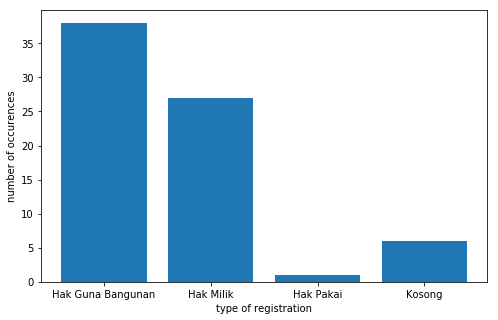

In [170]:
plt.figure(figsize = (2*len(np.unique(typehak)), 5))
plt.bar(np.unique(typehak), typehak_count)
plt.xlabel('type of registration')
plt.ylabel('number of occurences')